# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Признаки**

- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

## Подготовка данных

In [46]:
import pandas as pd
!pip install pandas-profiling
import pandas_profiling
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error

In [47]:
df_autos = pd.read_csv('/datasets/autos.csv')

In [48]:
display(df_autos.head(5))
print('-----------------------------------------------------------------')

display(df_autos.info())
print('-----------------------------------------------------------------')

display(df_autos.describe())
print('-----------------------------------------------------------------')

print('Кол-во пропусков:')
display(df_autos.isna().sum())
print('-----------------------------------------------------------------')

print('Кол-во дубликатов -', df_autos.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  La

None

-----------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-----------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-----------------------------------------------------------------
Кол-во дубликатов - 4


**Вывод:**<br>
- Есть признаки, которые никак не влияют на цену - DateCrawled, RegistrationMonth, DateCreated, NumberOfPictures, PostalCode и LastSeen. От них надо избавиться
- В признаках, влияющих на цену, есть пропуски
- В целевом признаке и признаке Power есть 0, наверняка есть другие выбросы
- В RegistrationYear указан минимальный год 1000, наверняка есть другие выбросы
- Есть дубликаты, от которых также надо избавиться
- В названиях признаков надо избавиться от верблюжьего стиля
- В признаках Gearbox и NotRepaired значения можно заменить на 1/0

### Предобобработка данных

In [49]:
# переведем названия колонок к единому (змеиному) стилю
df_autos.columns = df_autos.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df_autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [50]:
#избавимся от дубликатов:
df_autos.drop_duplicates(inplace=True)  

In [51]:
#избавимся от признаков, не влияющих на целевой признак:
df_autos.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'],
           axis=1,
           inplace=True)

**Целевой признак price**

In [52]:
#смотрим, сколько нулей в целевом признаке:
df_autos.price.value_counts()

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

In [53]:
#удалим все 0 из целевого признака:
df_autos = df_autos.query('price > 0')

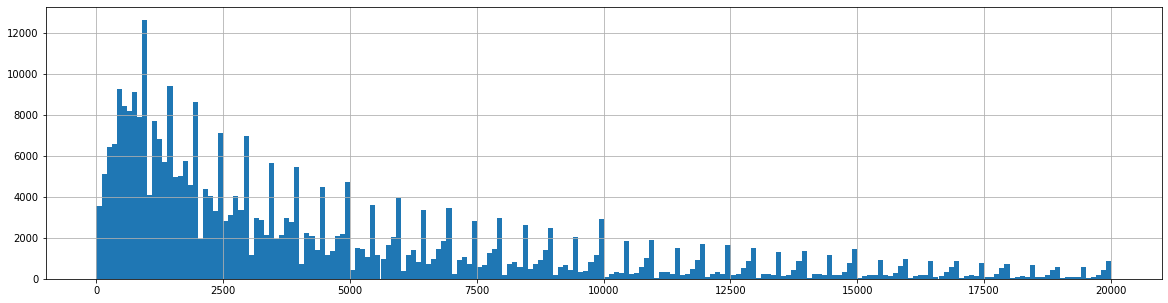

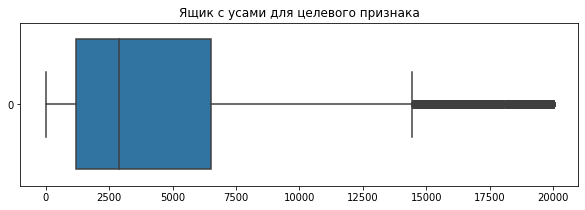

In [54]:
#глянем гистограмму и ящик с усами для целевого признака: 
df_autos.price.hist(bins=200, figsize=(20,5))

plt.figure(figsize=(10,3))
sns.boxplot(data=df_autos.price, orient='h')
plt.title('Ящик с усами для целевого признака')
plt.show()

In [55]:
#так как на гистограмме и ящике с усами странные данные у нуля, посмотрим квантиль:
df_autos.price.quantile([.05])

0.05    350.0
Name: price, dtype: float64

In [56]:
#доля строк, где цена меньше 350:
1 - df_autos.query('350 <= price').shape[0] / df_autos.shape[0]

0.045312331741333534

In [57]:
df_autos.loc[df_autos['price'] < 350]['price'].count()

15569

In [58]:
#избавимся от < 5% строк, где цена меньше 350:
df_autos = df_autos.query('350 <= price')

**Признак registrationyear**

In [59]:
#значения в registration_year:
df_autos.registration_year.value_counts()

2005    21178
2000    20959
1999    20668
2006    19632
2003    19373
        ...  
1946        1
1949        1
5300        1
8888        1
2290        1
Name: registration_year, Length: 133, dtype: int64

In [60]:
annual = df_autos.pivot_table(index='registration_year', values='brand', aggfunc='count')
annual.columns = ['quantity']
annual

,quantity
registration_year,
1000,19
1001,1
1039,1
1111,1
1234,2
...,...
8500,1
8888,1
9000,2


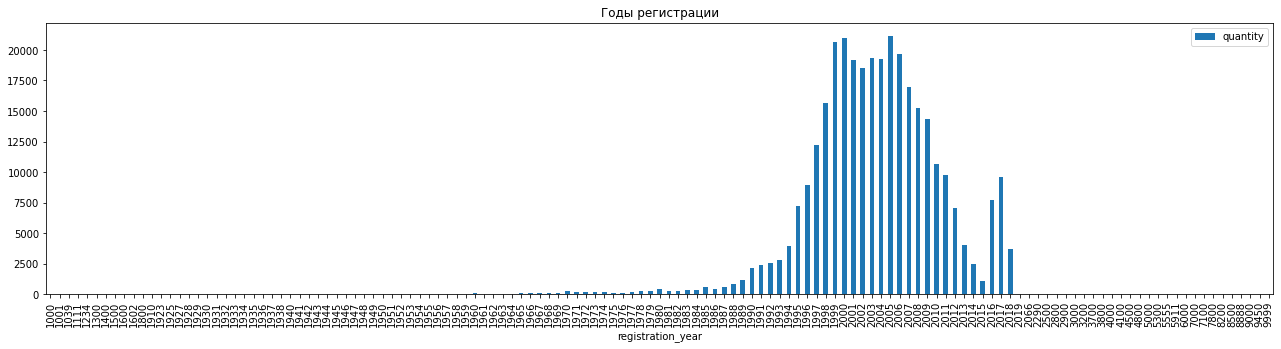

In [61]:
#график для registrationyear: 
annual.plot.bar(figsize = (22,5))
plt.title('Годы регистрации')
plt.show()

In [62]:
#самый поздний год выгрузки:
autos = pd.read_csv('/datasets/autos.csv')
autos.DateCrawled.max()

'2016-04-07 14:36:58'

Скорее всего вряд ли авто ранее 1975 и позже 2016 (органичение данных) были поставлены на учет и на продажу. Поэтому оставим в таблице только годы регистрации с 1975 по 2016:

In [63]:
df_autos = df_autos.query('1975 <= registration_year <= 2016')

**Признак power**

In [64]:
#значения в power:
df_autos.power.value_counts()

0        27195
75       20661
150      13563
60       13046
140      12266
         ...  
1082         1
1079         1
1703         1
13616        1
17019        1
Name: power, Length: 660, dtype: int64

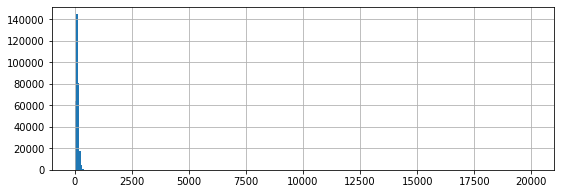

In [65]:
#гистограмма power:
df_autos.power.hist(bins=300, figsize=(9,3));

In [66]:
df_autos.power.describe()

count    312627.000000
mean        114.750469
std         183.493508
min           0.000000
25%          75.000000
50%         107.000000
75%         144.000000
max       20000.000000
Name: power, dtype: float64

Так как самое мощное по состоянию на 2022 год легковое авто имеет 1600лс, а самое слабое из представленных брендов авто - Citroen 2CV - имеет 9лс, то выбросим из таблицы всё, что выше и ниже этих границ:

In [67]:
df_autos = df_autos.query('9 <= power <= 1600')

**Признак kilometer**

In [68]:
#значения в kilometer:
df_autos.kilometer.value_counts()

150000    188205
125000     31035
100000     12408
90000      10077
80000       8855
70000       7660
60000       6725
50000       5542
40000       4420
30000       3767
20000       3107
5000        2441
10000        862
Name: kilometer, dtype: int64

Выбросов и аномалий нет

**Признак brand**

In [69]:
#значения в brand:
df_autos.brand.value_counts()

volkswagen        61719
bmw               31850
opel              30314
mercedes_benz     27055
audi              25308
ford              19140
renault           13070
peugeot            9096
fiat               7066
seat               5613
skoda              4897
mazda              4565
smart              4471
citroen            4069
toyota             3993
nissan             3836
hyundai            3059
mini               2950
volvo              2718
mitsubishi         2350
honda              2316
kia                2059
alfa_romeo         1890
suzuki             1874
chevrolet          1420
sonstige_autos     1398
chrysler           1124
dacia               800
porsche             605
subaru              604
jeep                562
daihatsu            557
saab                458
land_rover          457
jaguar              430
daewoo              366
lancia              344
rover               328
trabant             222
lada                151
Name: brand, dtype: int64

Неявных дубликатов не обнаружено 

**Признак gearbox**

In [70]:
#заменяем NaN на 'manual':
df_autos.fillna({'gearbox':'manual'}, inplace=True)

In [71]:
#заменим в gearbox значение manual на 1, auto - на 0:
df_autos.loc[(df_autos.gearbox == 'manual'), 'gearbox'] = 1   
df_autos.loc[(df_autos.gearbox == 'auto'), 'gearbox'] = 0

In [72]:
#поменяем тип на int:
df_autos.gearbox = df_autos.gearbox.astype('int')

**Признак repaired**

In [73]:
#заменим NaN на 'yes', так как обычно любая подержанная машина была в ремонте:
df_autos.fillna({'repaired':'yes'}, inplace=True)

In [128]:
#заменим в notrepaired значение yes на 1, no - на 0:
df_autos.loc[(df_autos.repaired == 'yes'), 'repaired'] = 1
df_autos.loc[(df_autos.repaired == 'no'), 'repaired'] = 0
#поменяем тип на int:
df_autos['repaired'] = df_autos['repaired'].astype(int)

**Признак model**

In [75]:
#заменим NaN на 'unknown':
df_autos.fillna({'model':'unknown'}, inplace=True)
df_autos.model.value_counts()

golf                  23832
other                 19130
3er                   17123
unknown                9899
polo                   9802
                      ...  
elefantino                4
serie_2                   3
rangerover                2
range_rover_evoque        2
serie_3                   2
Name: model, Length: 250, dtype: int64

**Признак vehicle_type**

In [76]:
#заменим пропуски на unknown:
df_autos.fillna({'vehicle_type':'unknown'}, inplace=True)
df_autos.vehicle_type.value_counts()

sedan          80819
small          65328
wagon          58018
bus            25986
convertible    18463
coupe          13997
suv            10855
unknown         9371
other           2267
Name: vehicle_type, dtype: int64

**Признак fuel_type**

In [77]:
#заменим пропуски на unknown:
df_autos.fillna({'fuel_type':'unknown'}, inplace=True)
df_autos.fuel_type.value_counts()

petrol      178630
gasoline     87330
unknown      13719
lpg           4624
cng            470
hybrid         201
other           68
electric        62
Name: fuel_type, dtype: int64

In [78]:
df_autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285104 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              285104 non-null  int64 
 1   vehicle_type       285104 non-null  object
 2   registration_year  285104 non-null  int64 
 3   gearbox            285104 non-null  int64 
 4   power              285104 non-null  int64 
 5   model              285104 non-null  object
 6   kilometer          285104 non-null  int64 
 7   fuel_type          285104 non-null  object
 8   brand              285104 non-null  object
 9   repaired           285104 non-null  object
dtypes: int64(5), object(5)
memory usage: 23.9+ MB


In [79]:
df_autos.corr()['price']

price                1.000000
registration_year    0.547324
gearbox             -0.252930
power                0.455279
kilometer           -0.392269
Name: price, dtype: float64

**Вывод по преобработке данных:**

*Избавились от:*
- признаков, которые никак не влияют на целевой признак
- верблюжьего стиля
- дубликатов
- выбросов в целевом признаке и признаках

*Заполнили пропуски в:*
- gearbox значением 'manual', и заменили значения на 1/0
- notrepaired значением 'yes', и заменили значения на 1/0
- model, vehicletype, fueltype значением 'unknown'

*В целом цена логично зависит:*
- прямо пропорционально от года регистрации, мощности
- обратно пропорционально от пробега, ремонта, типа коробки

*В результате обработки данных датафрейм сократился на ~18%, однако данных (285 104 строк) достаточно для обучения моделей.*

In [80]:
pandas_profiling.ProfileReport(df_autos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Обучение моделей

In [134]:
#выделяем признаки и целевой признак:
features_orig = df_autos.drop('price', axis=1)
target = df_autos.price

In [135]:
#разделим данные на обучающую и валидационную выборки в соотношении 60/40:
features_train, features_valid, target_train, target_valid = train_test_split(features_orig,
                                                                            target, 
                                                                            test_size=.4,
                                                                            random_state=12345)

#разделим валидационную выборку на валидационную и тестовую в соотношении 20/20:
features_test, features_valid, target_test, target_valid = train_test_split(features_valid,
                                                                                            target_valid,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

In [136]:
#кодируем признаки через OHE:
features_ohe = pd.get_dummies(features_orig, drop_first=True)
# 60/40:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe,
                                                                                            target,
                                                                                            test_size=.4,
                                                                                            random_state=12345)

# 20/20:
features_test_ohe, features_valid_ohe, target_test_ohe, target_valid_ohe = train_test_split(features_valid_ohe,
                                                                                            target_valid_ohe,
                                                                                            test_size=0.5,
                                                                                            random_state=12345)

In [137]:
#кодирем признаки через OE:
col = ['vehicle_type','fuel_type','brand','model']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

features_train_oe = features_train.copy()
features_train_oe[col] = pd.DataFrame(encoder.fit_transform(features_train[col]),
                                 columns=features_train[col].columns,
                                 index=features_train.index)

features_test_oe = features_test.copy()
features_test_oe[col] = pd.DataFrame(encoder.transform(features_test[col]),
                                columns=features_test[col].columns,
                                index=features_test.index)

features_valid_oe = features_valid.copy()
features_valid_oe[col] = pd.DataFrame(encoder.transform(features_valid[col]),
                                 columns=features_valid[col].columns,
                                 index=features_valid.index)

target_train_oe = target_train.copy()

target_test_oe = target_test.copy()

target_valid_oe = target_valid.copy()

In [102]:
#поглядим на размеры выборок:
for i in [features_train_ohe, features_test_ohe, features_valid_ohe, target_train_ohe, target_test_ohe, target_valid_ohe]:
    print(i.shape)    
    
print()

for i in [features_train_oe, features_test_oe, features_valid_oe, target_train_oe, target_test_oe, target_valid_oe]:
    print(i.shape)

print()
    
for i in [features_train, features_test, features_valid, target_train, target_test, target_valid]:
    print(i.shape)

(171062, 308)
(57021, 308)
(57021, 308)
(171062,)
(57021,)
(57021,)

(171062, 9)
(57021, 9)
(57021, 9)
(171062,)
(57021,)
(57021,)

(171062, 9)
(57021, 9)
(57021, 9)
(171062,)
(57021,)
(57021,)


### Модель LinearRegression

#### На выборках c OneHotEncoder

In [103]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 11.1 s, sys: 3.92 s, total: 15 s
Wall time: 15.1 s


LinearRegression()

In [104]:
%%time

target_predict = model_lr.predict(features_valid_ohe)

CPU times: user 138 ms, sys: 95.7 ms, total: 234 ms
Wall time: 217 ms


In [105]:
rmse_lr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** .5
rmse_lr_ohe

2498.5938588787785

#### На выборках c OrdinalEncoder

In [106]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train_oe, target_train_oe)

CPU times: user 131 ms, sys: 23.2 ms, total: 154 ms
Wall time: 145 ms


LinearRegression()

In [107]:
%%time

target_predict = model_lr.predict(features_valid_oe)

CPU times: user 40.3 ms, sys: 4.73 ms, total: 45 ms
Wall time: 40.8 ms


In [108]:
rmse_lr_oe = mean_squared_error(target_valid_oe, target_predict) ** .5
rmse_lr_oe

2910.048964934892

### Модель CatBoostRegressor

#### На выборках c OneHotEncoder

In [110]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_ohe, target_train_ohe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_ohe = (max(mts) * -1) ** .5
gscv_rsme_cbr_ohe

{'learning_rate': 0.5, 'random_state': 12345, 'verbose': False}
CPU times: user 5min 17s, sys: 3.25 s, total: 5min 20s
Wall time: 5min 39s


1547.7431619184276

In [109]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) #подставили лучшие параметры
model_cbr.fit(features_train_ohe, target_train_ohe)

CPU times: user 23.5 s, sys: 223 ms, total: 23.7 s
Wall time: 25.6 s


In [110]:
%%time

target_predict = model_cbr.predict(features_valid_ohe)

CPU times: user 127 ms, sys: 7.5 ms, total: 134 ms
Wall time: 132 ms


In [111]:
rmse_cbr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** .5
rmse_cbr_ohe

1523.3745595596151

#### На выборках c OrdinalEncoder

In [ ]:
%%time

model_cbr = CatBoostRegressor() 
parameters = [{'learning_rate':[.1, .5, .8], 'random_state':[12345], 'verbose':[False]}]

gscv = GridSearchCV(model_cbr, parameters, scoring='neg_mean_squared_error')
gscv.fit(features_train_oe, target_train_oe)

print(gscv.best_params_)

mts = gscv.cv_results_['mean_test_score']
    
gscv_rsme_cbr_oe = (max(mts) * -1) ** .5
gscv_rsme_cbr_oe

In [112]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, random_state=12345, verbose=False) 
model_cbr.fit(features_train_oe, target_train_oe)

CPU times: user 23.2 s, sys: 198 ms, total: 23.4 s
Wall time: 24.6 s


In [113]:
%%time

target_predict = model_cbr.predict(features_valid_oe)

CPU times: user 71.2 ms, sys: 388 µs, total: 71.6 ms
Wall time: 69.4 ms


In [114]:
rmse_cbr_oe = mean_squared_error(target_valid_oe, target_predict) ** .5
rmse_cbr_oe

1543.878303071845

#### На выборках без кодировки

In [115]:
%%time

model_cbr = CatBoostRegressor(learning_rate=.5, iterations=200, random_state=12345, verbose=False, 
                              cat_features=['vehicle_type','fuel_type','brand','model']) 

model_cbr.fit(features_train, target_train)

CPU times: user 25.7 s, sys: 278 ms, total: 25.9 s
Wall time: 26.8 s


In [116]:
%%time

target_predict = model_cbr.predict(features_valid)

CPU times: user 136 ms, sys: 3.41 ms, total: 139 ms
Wall time: 136 ms


In [117]:
rmse_cbr = mean_squared_error(target_valid, target_predict) ** .5
rmse_cbr

1582.5692524805868

### Модель LightGBMRegressor

#### На выборках c OneHotEncoder

In [ ]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]

clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train_ohe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

In [146]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=.3, num_leaves=200, random_state=12345)
model_lgbmr.fit(features_train_ohe, target_train_ohe)

CPU times: user 13.7 s, sys: 186 ms, total: 13.9 s
Wall time: 13.9 s


LGBMRegressor(learning_rate=0.3, num_leaves=200, random_state=12345)

In [147]:
%%time

target_predict = model_lgbmr.predict(features_valid_ohe)

CPU times: user 841 ms, sys: 70.4 ms, total: 911 ms
Wall time: 899 ms


In [148]:
rsme_lgbmr_ohe = mean_squared_error(target_valid_ohe, target_predict) ** .5
rsme_lgbmr_ohe

1516.9919896611693

#### На выборках c OrdinalEncoder

In [ ]:
%%time

model_lgbmr = LGBMRegressor() 
parameters = [{'num_leaves':[25, 50, 100, 200], 'learning_rate':[.1, .3, .5], 'random_state':[12345]}]


clf = GridSearchCV(model_lgbmr, parameters, scoring='neg_mean_squared_error')
clf.fit(features_train_oe, target_train_oe)

print(clf.best_params_)
print()

mts = clf.cv_results_['mean_test_score']

rsme_lgbmr = (max(mts) * -1) ** .5
rsme_lgbmr

In [139]:
%%time

model = LGBMRegressor(learning_rate=.3, num_leaves=100, random_state=12345)
model.fit(features_train_oe, target_train_oe)

CPU times: user 22.2 s, sys: 15.7 ms, total: 22.2 s
Wall time: 22.3 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=12345)

In [140]:
%%time

target_predict = model.predict(features_valid_oe)

CPU times: user 449 ms, sys: 0 ns, total: 449 ms
Wall time: 496 ms


In [141]:
rsme_lgbmr_oe = mean_squared_error(target_valid_oe, target_predict) ** .5
rsme_lgbmr_oe

1539.2341540533155

**Вывод:**

Обучили 3 модели - Линейную Регрессию, CatBoostRegressor и LGBMRegressor - со сменой гиперпараметров и на разных выборках - изначальные, с обычной кодировкой и OHE.<br>
Часть моделей дали `RMSE > 2500`, поэтому финальный вывод будем делать только на тех моделях, которые дали RMSE < 2500

## Анализ Моделей

In [142]:
#создадим сводную таблицу по показателям RMSE < 2500, времени обучения модели и времени предсказания модели:
index = ['Линейная регрессия с OHE',
         'CatBoostRegressor с OHE',
         'CatBoostRegressor с OE',
         'CatBoostRegressor без кодировки',
         'LGBMRegressor с OHE',
         'LGBMRegressor с OE'
        ]

data = {'RMSE':[rmse_lr_ohe,
                rmse_cbr_ohe,
                rmse_cbr_oe,
                rmse_cbr,
                rsme_lgbmr_ohe,
                rsme_lgbmr_oe],
        
        'Время обучения модели':[15,
                                 23.7,
                                 23.4,
                                 25.9,
                                 15.8,
                                 22.2],
        
        'Время предсказания модели':[0.23,
                                     0.13,
                                     0.07,
                                     0.13,
                                     0.96,
                                     0.44]
       }

kpi_data = pd.DataFrame(data=data, index=index)

#введем столбец Рейтинг с весами:
kpi_data['Рейтинг'] = (kpi_data['RMSE'] * .34 \
                       + kpi_data['Время обучения модели'] * .33 \
                       + kpi_data['Время предсказания модели'] * .33)

kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor с OHE,1516.991990,15.8,0.96,521.308076
CatBoostRegressor с OHE,1523.374560,23.7,0.13,525.811250
LGBMRegressor с OE,1539.234154,22.2,0.44,530.810812
CatBoostRegressor с OE,1543.878303,23.4,0.07,532.663723
CatBoostRegressor без кодировки,1582.569252,25.9,0.13,546.663446
Линейная регрессия с OHE,2498.593859,15.0,0.23,854.547812


Промежуточный вывод по сводной таблице:

Лучшей моделью по RMSE, времени обучения модели, времени предсказания модели, если считать эти параметры одинаково важными для принятия решения, является *`LGBMRegressor` с выборками c OHE*. <br>Аутсайдер рейтинга - модель `LinearRegression`.

**Протестируем нашу лучшую модель `LGBMRegressor` c OHE**

In [149]:
%%time

target_predict_ohe = model_lgbmr.predict(features_test_ohe)

CPU times: user 872 ms, sys: 55.7 ms, total: 928 ms
Wall time: 857 ms


In [150]:
final_rsme_lgbmr_ohe = mean_squared_error(target_test_ohe, target_predict_ohe) ** .5
final_rsme_lgbmr_ohe

1524.3514261402938

In [152]:
#добавим в сравнительную таблицу финальные данные:
kpi_data.loc['Лучшая модель на тесте'] = [final_rsme_lgbmr_ohe, 15.8, 0.92, final_rsme_lgbmr_ohe * .34 + 15.8 * .33 + 0.92 * .33]
kpi_data.sort_values(by = 'Рейтинг', ascending=True)

,RMSE,Время обучения модели,Время предсказания модели,Рейтинг
LGBMRegressor с OHE,1516.991990,15.8,0.96,521.308076
Лучшая модель на тесте,1524.351426,15.8,0.92,523.797085
CatBoostRegressor с OHE,1523.374560,23.7,0.13,525.811250
LGBMRegressor с OE,1539.234154,22.2,0.44,530.810812
CatBoostRegressor с OE,1543.878303,23.4,0.07,532.663723
CatBoostRegressor без кодировки,1582.569252,25.9,0.13,546.663446
Линейная регрессия с OHE,2498.593859,15.0,0.23,854.547812


Финальная проверка на лучшей модели - LGBMRegressor с выборками c OHE - дала `RMSE 1524`, общее место в рейтинге после проверки на тестовых данных - `2`.

## Вывод

- Загрузили данные и провели их предобработку - очистку, заполнение, удаление лишних данных
- Сравнили 3 модели с разными гиперпараметрами и выборками
- Выбрали лучшую модель по 3 показателям - RMSE, время обучения и время предсказания и проверили ее на тестовой выборке

**Итог:**  наилучшей моделью стала *`LGBMRegressor` с OHE*, которая на финальном тестировании показала `RMSE 1524`, несмотря на требуемое бОльшее время на обучение и предсказание. Если время не ограниченно, лучше выбрать именно эту модель.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей